In [71]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation, digits
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
color = ['#247BA0', '#F6511D', '#7FB800', '#FFB400', '#F25F5C', '#50514F']

The goal of the this project is to use machine learning algorithm to categorize article based on the text content.

Reading the data files first

In [102]:
bbc_train_df = pd.read_csv('BBC News Train.csv')
bbc_test_df = pd.read_csv('BBC News Test.csv')

In [103]:
bbc_train_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


The training dataset contains 1,490 samples, and each row consists of the article id, content and category

In [6]:
bbc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


The training dataset seems to be balance, the number of sport and business articles are slightly more than other categories.

In [7]:
bbc_train_df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

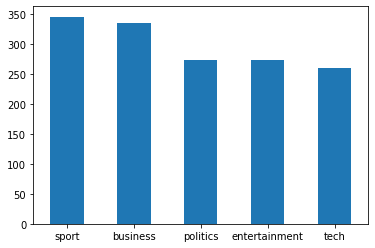

In [8]:
bbc_train_df['Category'].value_counts().plot.bar(x = 'lab', y = 'val', rot = 0)

Cleaning the text content by transforming into lower letters, removing stop words and punctuation, and lemmatizing words

In [104]:
bbc_train_df['clean_text'] = bbc_train_df['Text'].str.lower()
stop_words = list(stopwords.words('english'))
punctuation = list(punctuation)
clean_text_list = []
lemmatizer = WordNetLemmatizer()
for row in bbc_train_df['clean_text']:
    text_split = row.split()
    clean_temp = [lemmatizer.lemmatize(word) for word in text_split if word not in stop_words and word not in punctuation]
    clean_temp = ' '.join(clean_temp)
    clean_text_list.append(clean_temp)
bbc_train_df['clean_text'] = pd.Series(clean_text_list)

Using scikit learn TfidfVectorizer function to extract features from raw text.

In [105]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2,
                                   max_features = 1000,
                                   stop_words = 'english')
tfidvec_train = tfidf_vectorizer.fit_transform(bbc_train_df['clean_text'])

Building predict function to transform tfidf matrix in to prediction

In [106]:
def predict(nmf_matrix):
    sorted_index = np.argsort(nmf_matrix)
    n_sample, n_cat = sorted_index.shape
    prediction = [[sorted_index[i][n_cat - 1]] for i in range(n_sample)]
    cat = np.empty(n_sample, dtype = np.int64)
    for i in range(n_sample):
        cat[i] = prediction[i][0]
    return cat

Building label_permute_compare function to calculate model accuracy and return label order

In [107]:
def label_permute_compare(ytdf,yp,n=5):
    acc = 0
    labelorder = ()
    for e in itertools.permutations(ytdf['Category'].unique()):
        df_label = pd.DataFrame({'model_label': range(5), 'model_Category': list(e)})
        df_model_label = pd.merge(pd.DataFrame({'model_label': yp, 'true_Category': ytdf['Category']}), df_label, on = 'model_label')
        accuracy_c = df_model_label[df_model_label['true_Category']==df_model_label['model_Category']].shape[0]/df_model_label.shape[0]
        if accuracy_c > acc:
            acc = accuracy_c
            labelorder = tuple(pd.merge(pd.DataFrame({'model_Category': ytdf['Category'].unique()}),
                                        df_label, how = 'left')['model_label'])
            label_order = df_label
    return (labelorder, acc, label_order)

Trying different combinations of attributes in the NMF model to find out the best model

In [108]:
best_init = ''
best_solver = ''
best_beta_loss = ''
best_acc= 0

for init in ['nndsvd', 'nndsvda', 'nndsvdar']:
    for solver in ['cd', 'mu']:
        for beta_loss in ['frobenius', 'kullback-leibler', 'itakura-saito']:
            try:
                nmf = NMF(n_components = 5, random_state = 1, l1_ratio = 0.5,
                      init = init,
                      solver = solver,
                      beta_loss = beta_loss).fit(tfidvec_train)
                nmf_matrix = nmf.transform(tfidvec_train)
                yp = predict(nmf_matrix)
                labelorder, acc, label_order = label_permute_compare(bbc_train_df, yp, n = 5)
                print(init, solver, beta_loss, acc)
                if acc > best_acc:
                    best_acc= acc
                    best_init = init
                    best_solver = solver
                    best_beta_loss = beta_loss
            except:    
                pass

nndsvd cd frobenius 0.8919463087248322
nndsvd mu frobenius 0.8798657718120806
nndsvd mu kullback-leibler 0.9114093959731544
nndsvda cd frobenius 0.8919463087248322
nndsvda mu frobenius 0.9013422818791946
nndsvda mu kullback-leibler 0.9476510067114094
nndsvdar cd frobenius 0.8919463087248322
nndsvdar mu frobenius 0.9026845637583892
nndsvdar mu kullback-leibler 0.9476510067114094


In [109]:
nmf = NMF(n_components = 5, random_state = 1, l1_ratio = 0.5,
          init = best_init,
          solver = best_solver,
          beta_loss = best_beta_loss).fit(tfidvec_train)
nmf_matrix = nmf.transform(tfidvec_train)
yp = predict(nmf_matrix)
labelorder, acc, label_order = label_permute_compare(bbc_train_df, yp, n = 5)
print(best_init, best_solver, best_beta_loss, ' leads the best performance.')
print(str(labelorder) + ' accuracy is ' +  str(acc))

nndsvda mu kullback-leibler  leads the best performance.
(3, 4, 0, 1, 2) accuracy is 0.9476510067114094


Cleaning the test dataset

In [110]:
bbc_test_df['clean_text'] = bbc_test_df['Text'].str.lower()
stop_words = list(stopwords.words('english'))
punctuation = list(punctuation)
clean_text_list = []
lemmatizer = WordNetLemmatizer()
for row in bbc_test_df['clean_text']:
    text_split = row.split()
    clean_temp = [lemmatizer.lemmatize(word) for word in text_split if word not in stop_words and word not in punctuation]
    clean_temp = ' '.join(clean_temp)
    clean_text_list.append(clean_temp)
bbc_test_df['clean_text'] = pd.Series(clean_text_list)

Using the model above to make predictions on test data

In [111]:
tfidvec_test = tfidf_vectorizer.transform(bbc_test_df['clean_text'])

In [112]:
nmf_matrix_test = nmf.transform(tfidvec_test)
yp_test = predict(nmf_matrix_test)

In [115]:
df_model_label_test = pd.merge(pd.DataFrame({'ArticleId': bbc_test_df['ArticleId'], 'model_label': yp_test}), label_order, on = 'model_label', how = 'left')

In [116]:
submission_nmf = df_model_label_test[['ArticleId', 'model_Category']]
submission_nmf.columns = ['ArticleId', 'Category']
submission_nmf.to_csv('submission_nmf.csv', index = False)

This submission scores 0.93877

In the following, we use supervised machine learning random forest to make the prediction

In [117]:
X_train = bbc_train_df['clean_text']
Y_train = bbc_train_df['Category']
X_test = bbc_test_df['clean_text']

In [119]:
clf = Pipeline([('tffidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(n_estimators=100))])
clf.fit(X_train, Y_train)

Pipeline(steps=[('tffidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [120]:
clf.score(X_train, Y_train)

1.0

In [121]:
Y_predict = clf.predict(X_test)

In [124]:
submission_randomforest = pd.DataFrame({'ArticleId': bbc_test_df['ArticleId'], 'Category': Y_predict})
submission_randomforest.to_csv('submission_randomforest.csv', index = False)

This submission scores 0.96326

Using Non-Negative Matrix Factorization, we have a training score of 94.77%, and the test score is 93.88%. Using Random Forest Classifier, we have a training score of 100%, and the test score is 96.32%. It seems that supervised machine learning got a better result by comparing with unsupervised machine learning, but overall the results of these models are both good.